<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">TM1py:</span> Time Series Forecasting</h1>
<hr>


The first step you should complete before actually stepping through this code is to install all required dependencies. Assuming you already have Anaconda installed, you'll only need to install TM1py. To do this run the following command:
<pre>pip install TM1py</pre>

You'll also need to install pystan and the facebook Prophet time series package. To do this run the following commands: 

<pre>pip install pystan</pre>

<pre>pip install fbprophet</pre>

## Step 1: Import the required modules
<p> Before stepping through the process there are a number of modules that need to be imported. This model relies heavily on <a href="https://pandas.pydata.org/">Pandas</a> for data manipulation and transformation and <a href="https://code.cubewise.com/tm1py/">TM1py</a> for interacting with the TM1 API. 

In [1]:
#import tm1 service module
from TM1py.Services import TM1Service
#import tm1 utils module
from TM1py.Utils import Utils
#import pandas
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
#inline plotting for matplotlib
%matplotlib inline
#import statsmodels package
from fbprophet import Prophet

## Step 2: Setup your TM1 parameters

### TM1 Server Parameters
Populate your TM1 server parameters below. In this example the script is connecting to the local server and 8882 for the HTTP port.

In [2]:
#Server address
address = 'localhost'
#HTTP port number - this can be found in your config file
port = '8892'
#username
user = 'admin'
#password
password = 'apple'
#SSL parameter - this can be found in your config file
ssl = True

## Step 3: Get TM1 Data
The following code obtains a data set from TM1 based on the cube and view specified above. The resulting dataset is transformed into a pandas dataframe for statistical analysis. 

For more on pandas and dataframes check out this <a href="https://pandas.pydata.org/pandas-docs/stable/tutorials.html">pandas tutorial</a>.

Before importing any data, create the view you would like to import into the data frame. Populate the fields below.

In [3]:
#specify the cube
cube_name = 'Retail'
#specify the view
view_name = 'Time Series'

In [4]:
with TM1Service(address= address, port=port, user=user, password=password, ssl=ssl) as tm1:
    
    # Extract pnl data from specified cube view
    raw_data = tm1.cubes.cells.get_view_content(cube_name=cube_name, view_name=view_name, private=False)

    # Build pandas DataFrame fram raw cellset data
    df = Utils.build_pandas_dataframe_from_cellset(raw_data, multiindex=False)

## Step 4: Time Series Forecast with Prophet

In [5]:
ts = df
ts.dtypes
ts['Date'] = ts['Year'] + '-' + ts['Period']
ts['Date'] = pd.DatetimeIndex(ts['Date'])
ts = ts.rename(columns={'Date': 'ds',
                        'Values': 'y'})

Rather than looping through each region and product within the data set, the following cell creates a subset of data to forecast. If you'd like to forecast for an alternate region/product combination this is where you're able to make the change by subbing out Region <i>13</i> and Product <i>315</i>. 

In [6]:
region = '13'
product = '315'

sub = ts[ts['Region']==region]
sub = sub[sub['Product']==product]

In [7]:
sub_model = Prophet(interval_width=0.95)
sub_model.fit(sub)

In [8]:
#specify the number of future periods
future_dates = sub_model.make_future_dataframe(periods=24, freq='MS')

In [9]:
forecast = sub_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2018-08-01,115.676169,108.099447,123.245252
56,2018-09-01,117.624557,109.524479,125.498587
57,2018-10-01,121.015638,112.628860,129.697264
58,2018-11-01,124.491953,115.375530,134.142216
59,2018-12-01,126.283804,116.638105,136.223047


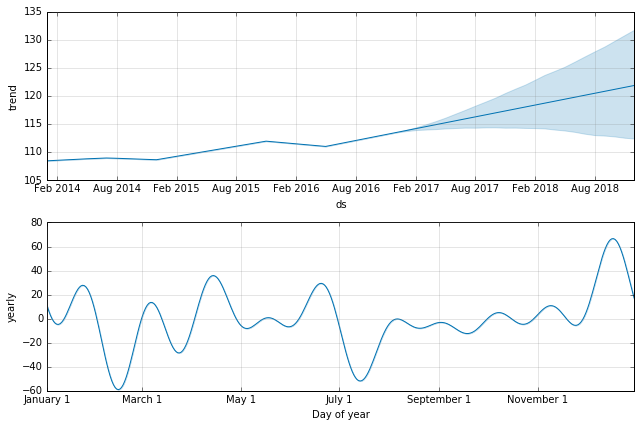

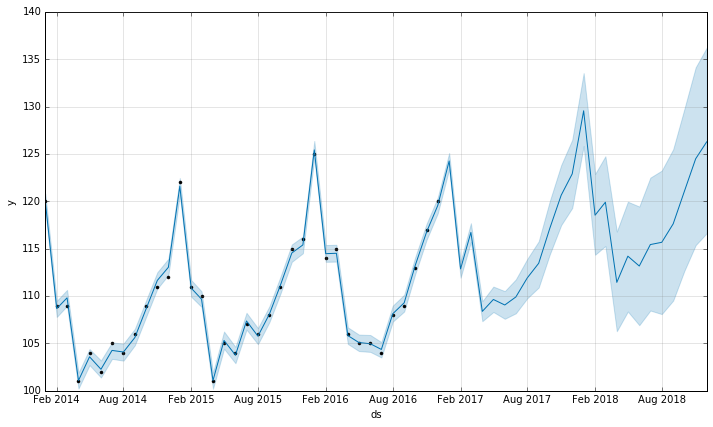

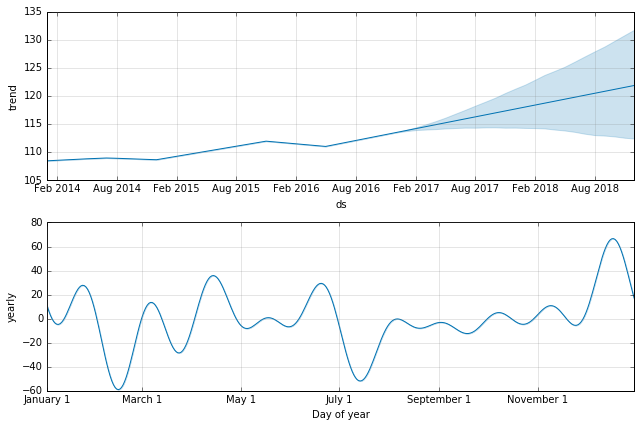

In [10]:
sub_model.plot(forecast,
              uncertainty=True)

sub_model.plot_components(forecast)

## Step 5: Send the data back into TM1

In [11]:
#Combine the forecast dataframe and our original subset
sub = sub.set_index('ds')
forecast = forecast.set_index('ds')

In [12]:
result = pd.concat([sub, forecast], axis = 1)

In [13]:
#fill out other dimensions
result['Version'] = result.Version.fillna('3')
result['Currency'] = result.Currency.fillna('Local')
result['Region'] = result.Region.fillna(region)
result['Product'] = result.Product.fillna(product)
result['Retail Measure'] = result['Retail Measure'].fillna('Sales Amount')

#make ds accessible
result = result.reset_index()
result['Year'] = pd.DatetimeIndex(result['ds']).year
result['Period'] = pd.DatetimeIndex(result['ds']).month

In [14]:
with TM1Service(address= address, port=port, user=user, password=password, ssl=ssl) as tm1:
    
    # cellset to store the new data
    cellset = {}
    # Populate cellset with coordinates and value pairs
    for index, row in result.iterrows():
        cellset[(row['Year'], row['Period'], 'Forecast', row['Product'], row['Currency'], row['Region'],row['Retail Measure'])] = row['yhat']        
        tm1.cubes.cells.write_values('Retail', cellset)